In [1]:
from PIL import Image
import time
from keras.models import load_model
import numpy as np
from vis.visualization import visualize_cam, overlay
from vis.utils import utils
from keras.activations import linear

import matplotlib.pyplot as plt
import cv2

from vis.visualization import visualize_cam
from math import sqrt
import time
import matplotlib.cm as cm
import matplotlib as mpl

from sklearn.preprocessing import MinMaxScaler
import sklearn
from tqdm import tqdm

Using TensorFlow backend.
/home/isua/anaconda3/envs/CAPRI/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/isua/anaconda3/envs/CAPRI/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/isua/anaconda3/envs/CAPRI/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/isua/anaconda3/envs/CAP

In [2]:
#from importlib_metadata import version

In [3]:
def my_load_img(f):
    img = Image.open(f)
    fp = img.fp
    img.load()
    fp.closed
    return img

def preprocess_image(path_imagen):
    imagen_original = my_load_img(path_imagen)
    imagen = imagen_original.convert("L")
    imagen = np.array(imagen.resize((150,150)))
    imagen = np.expand_dims(np.array(imagen),2) # /255
    imagen = np.divide(imagen, imagen.mean())
    return imagen

In [4]:
def heatmap_generator_othercolor(path_imagen, paths_modelos,
                                 real_class):
    
    started_time = time.time()
        
    # Prediction of each class
    imagen = preprocess_image(path_imagen)
    aux = np.array([imagen])
    
    modelos = [load_model(p) for p in tqdm(paths_modelos)]
    predictions = np.array([m.predict(aux)[0] for m in modelos])
    prediction_neuron0 = predictions[:,0].mean()
    prediction_neuron1 = predictions[:,1].mean()    
    
##################################################################################################################
########################                NEURON 0                                          ########################
##################################################################################################################

    ################################
    # Generate heatmap of neuron 0 #
    ################################
    heatmaps_neuron0 = []
    for m in tqdm(modelos):
        layer    = -1
        m.layers[layer].activation = linear
        model_with_linear_output = utils.apply_modifications(m)
        #exponente = 0.7
        #porc = 0.8
        imagen = preprocess_image(path_imagen)
        grads_0  = visualize_cam(model_with_linear_output,
                                 layer, filter_indices=0,
                                 seed_input=imagen,
                                 backprop_modifier='guided')
        
        ###grads_0 = grads_0[:, :, 0]
        heatmaps_neuron0.append(grads_0)
        
        
    ################################
    # Get mean and std of heatmaps #
    ################################    
    # Heatmap of mean of all heatmaps of neuron 0
    aux0             = np.array(heatmaps_neuron0)
    res_mean_neuron0 = aux0.mean(axis=0)
    res_std_neuron0  = aux0.std(axis=0)
        
        
##################################################################################################################
########################                NEURON 1                                          ########################
##################################################################################################################        
        
    ################################
    # Generate heatmap of neuron 1 #
    ################################
    
    heatmaps_neuron1 = []
    for p in tqdm(paths_modelos):
        m        = load_model(p)
        layer    = -1
        m.layers[layer].activation = linear
        model_with_linear_output = utils.apply_modifications(m)
        
        imagen = preprocess_image(path_imagen)
        grads_1  = visualize_cam(model_with_linear_output,
                                 layer, filter_indices=1,
                                 seed_input=imagen,
                                 backprop_modifier='guided')
        
        ###grads_1 = grads_1[:, :, 0]
        heatmaps_neuron1.append(grads_1)
        
    ################################
    # Get mean and std of heatmaps #
    ################################  
    
    # Heatmap of mean of all heatmaps of neuron 1
    aux1             = np.array(heatmaps_neuron1)
    res_mean_neuron1 = aux1.mean(axis=0)
    res_std_neuron1  = aux1.std(axis=0)
    
    maximo_mean = max(res_mean_neuron0.max(), res_mean_neuron1.max())
    maximo_std  = max(res_std_neuron0.max(), res_std_neuron1.max())
    
    
    # Plot
    f, axs = plt.subplots(2,3, figsize=(15,15))
    (ax1, ax2, ax3), (ax4, ax5, ax6) = axs
    
    imagen = preprocess_image(path_imagen)
    
    ax1.imshow(imagen[:, :, 0], cmap='gray') 
    ax2.imshow(imagen[:, :, 0], cmap='gray')
    ax3.imshow(imagen[:, :, 0], cmap='gray')
    ax4.imshow(imagen[:, :, 0], cmap='gray')
    ax6.imshow(imagen[:, :, 0], cmap='gray')
    
    ax1.set_ylabel('Mean', fontsize=20)
    ax1.set_title('Neuron 0,\n prob = '+str(round(prediction_neuron0, 3)), fontsize=20)
    ax3.set_title('Neuron 1,\n prob = '+str(round(prediction_neuron1, 3)), fontsize=20)
    ax4.set_ylabel('Std', fontsize=20)
    ax5.axis('off')
    
    pos = ax1.imshow(res_mean_neuron0, cmap='hot', alpha=0.5)
    f.colorbar(pos, ax=ax1)
    #pos.set_clim(0, 1)
    pos.set_clim(0, maximo_mean)
    
    pos = ax3.imshow(res_mean_neuron1, cmap='hot', alpha=0.5)
    f.colorbar(pos, ax=ax3) 
    #pos.set_clim(0, 1)
    pos.set_clim(0, maximo_mean)
    
    pos = ax4.imshow(res_std_neuron0, cmap='hot', alpha=0.5)
    f.colorbar(pos, ax=ax4)
    #pos.set_clim(0, 1)
    pos.set_clim(0, maximo_mean)
    
    pos = ax6.imshow(res_std_neuron1, cmap='hot', alpha=0.5)
    f.colorbar(pos, ax=ax6)
    #pos.set_clim(0, 1)
    pos.set_clim(0, maximo_mean)
    

    ended_time = time.time()
    total_time = ended_time - started_time
    print('Total time:', total_time)
    aux = aux0, res_mean_neuron0, res_std_neuron0, aux1, res_mean_neuron1, res_std_neuron1
    
    return aux

In [5]:
#model0 = load_model('../model_comparison_10kfold/model_102/saved_model/manuel_version102_kfold10_0.h5')
#model1 = load_model('../model_comparison_10kfold/model_102/saved_model/manuel_version102_kfold10_1.h5')
#model2 = load_model('../model_comparison_10kfold/model_102/saved_model/manuel_version102_kfold10_2.h5')
#model3 = load_model('../model_comparison_10kfold/model_102/saved_model/manuel_version102_kfold10_3.h5')
#model4 = load_model('../model_comparison_10kfold/model_102/saved_model/manuel_version102_kfold10_4.h5')
#model5 = load_model('../model_comparison_10kfold/model_102/saved_model/manuel_version102_kfold10_5.h5')
#model6 = load_model('../model_comparison_10kfold/model_102/saved_model/manuel_version102_kfold10_6.h5')
#model7 = load_model('../model_comparison_10kfold/model_102/saved_model/manuel_version102_kfold10_7.h5')
#model8 = load_model('../model_comparison_10kfold/model_102/saved_model/manuel_version102_kfold10_8.h5')
#model9 = load_model('../model_comparison_10kfold/model_102/saved_model/manuel_version102_kfold10_9.h5')

paths_modelos = [
    '/home/isua/Escritorio/experiment_kfold/model_comparison_10kfold/model_102/saved_model/manuel_version102_kfold10_0.h5',
    '/home/isua/Escritorio/experiment_kfold/model_comparison_10kfold/model_102/saved_model/manuel_version102_kfold10_1.h5',
    '/home/isua/Escritorio/experiment_kfold/model_comparison_10kfold/model_102/saved_model/manuel_version102_kfold10_2.h5',
    '/home/isua/Escritorio/experiment_kfold/model_comparison_10kfold/model_102/saved_model/manuel_version102_kfold10_3.h5',
    '/home/isua/Escritorio/experiment_kfold/model_comparison_10kfold/model_102/saved_model/manuel_version102_kfold10_4.h5',
    '/home/isua/Escritorio/experiment_kfold/model_comparison_10kfold/model_102/saved_model/manuel_version102_kfold10_5.h5',
    '/home/isua/Escritorio/experiment_kfold/model_comparison_10kfold/model_102/saved_model/manuel_version102_kfold10_6.h5',
    '/home/isua/Escritorio/experiment_kfold/model_comparison_10kfold/model_102/saved_model/manuel_version102_kfold10_7.h5',
    '/home/isua/Escritorio/experiment_kfold/model_comparison_10kfold/model_102/saved_model/manuel_version102_kfold10_8.h5',
    '/home/isua/Escritorio/experiment_kfold/model_comparison_10kfold/model_102/saved_model/manuel_version102_kfold10_9.h5',
]

  0%|          | 0/10 [00:00<?, ?it/s]WARNING: Logging before flag parsing goes to stderr.
W0319 20:17:40.091724 139778959451968 deprecation_wrapper.py:119] From /home/isua/anaconda3/envs/CAPRI/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0319 20:17:40.112852 139778959451968 deprecation_wrapper.py:119] From /home/isua/anaconda3/envs/CAPRI/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:245: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0319 20:17:40.113852 139778959451968 deprecation_wrapper.py:119] From /home/isua/anaconda3/envs/CAPRI/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0319 20:17:40.114406 139778959451968 deprecation_wrapper.py:119] From /home/isua/anaconda3/envs/CAPRI/lib/pyt

Total time: 1938.7415661811829


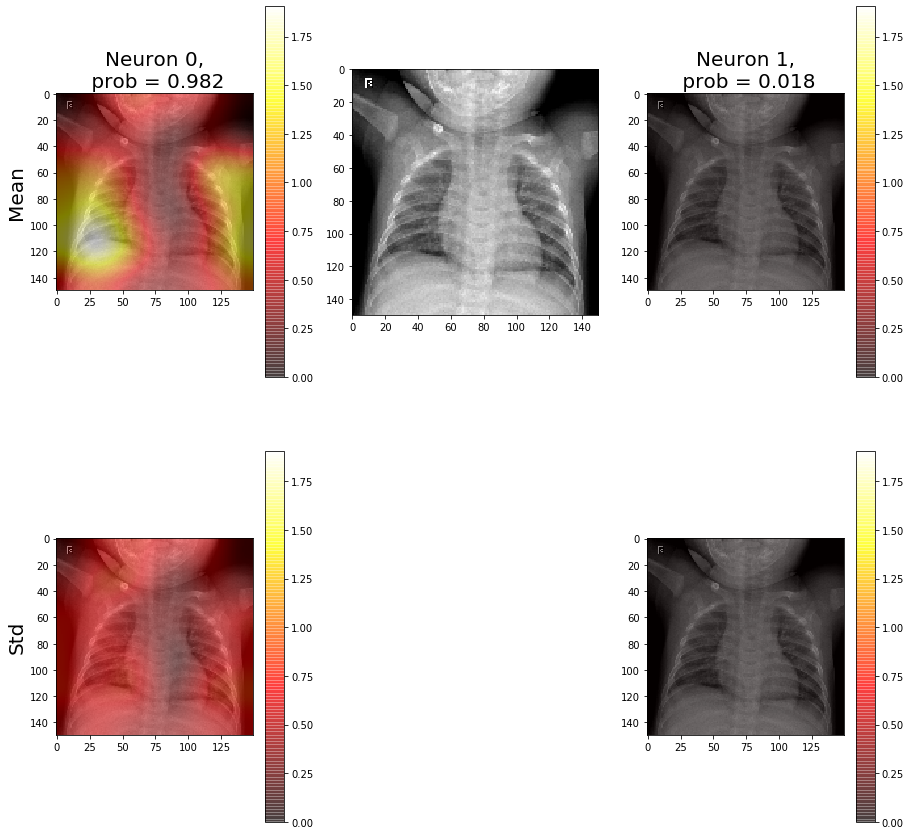

In [6]:
image_path = '/home/isua/Escritorio/chest-xray-pneumonia (1)/dataset_xrays/train/NORMAL/IM-0609-0001.jpeg'
#image_path = '../NORMAL/IM-0609-0001.jpeg'
#model_list = [model0, model1,
#              model2, model3, model4,
#              model5, model6, model7, model8, model9
#             ]
start = time.time()
aux_normal = heatmap_generator_othercolor(image_path,
                                          #model_list,
                                          paths_modelos,
                                          'Non consolidation')
end = time.time()

Esta imagen parece estar correcta, ya que coge practicamente todo el pulmón en la neurona 0, mientras que da una media cercana a 0 para la clase 1, además la std de la neurona 1 es prácticamente nula.

100%|██████████| 10/10 [37:51<00:00, 227.12s/it]


Total time: 4666.358895778656


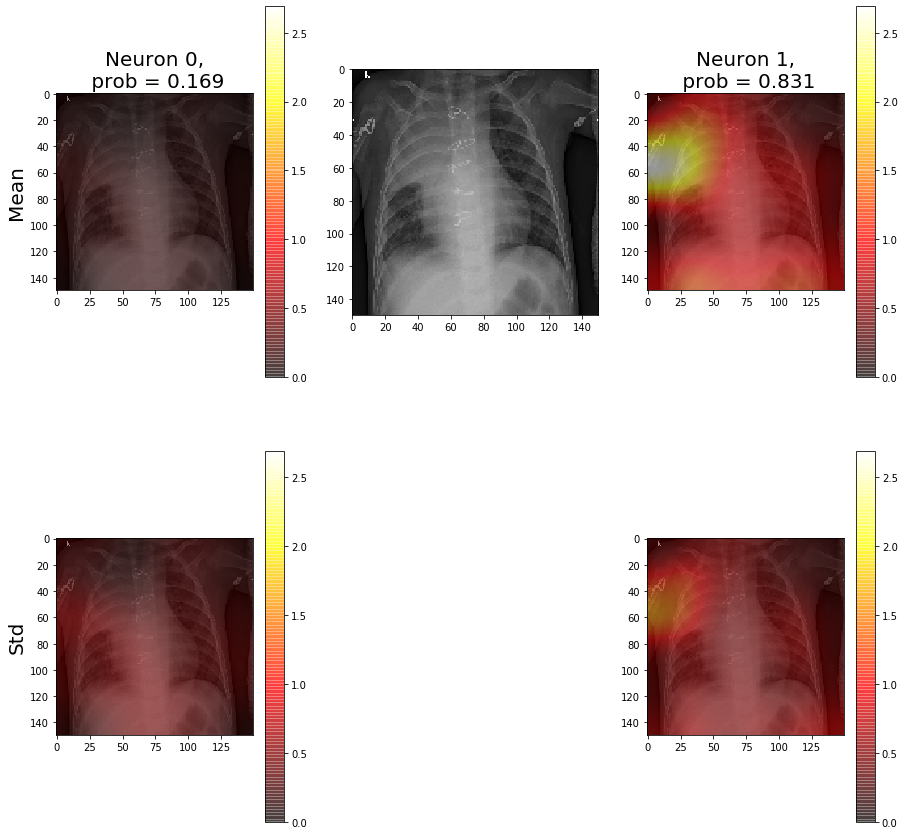

In [8]:
image_path = '/home/isua/Escritorio/chest-xray-pneumonia (1)/dataset_xrays/train/PNEUMONIA/person383_bacteria_1751.jpeg'
#image_path = '../PNEUMONIA/person383_bacteria_1751.jpeg'
#model_list = [model0, model1, model2, model3, model4,
#              model5, model6, model7, model8, model9]
start = time.time()
aux_consolidate = heatmap_generator_othercolor(image_path,
                                               paths_modelos,
                                               'consolidation')
end = time.time()